In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install pca
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px

#codificación
from sklearn.preprocessing import StandardScaler
#!pip install feature_engine
import feature_engine.imputation as fe_imp

#PCA
from sklearn.decomposition import PCA
from pca import pca

#modelizacion y métricas
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import time

import warnings
warnings.filterwarnings('ignore')

# LECTURA

In [ ]:
meteo = pd.read_csv("/content/drive/MyDrive/CURSO 2022-2023/Programación/Datathon_2023/código/DATOS_METEO.TXT", sep='|', decimal='.', encoding='UTF-8')

In [ ]:
dftrain = pd.read_csv("/content/drive/MyDrive/CURSO 2022-2023/Programación/Datathon_2023/código/UH_2023_TRAIN.txt", sep='|', decimal='.', encoding='UTF-8')

# DEPURACION

### Funciones

In [ ]:
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), #clip colapsa en un límite
                  upper=s.quantile(1-limits[1], interpolation='higher'))

def gestiona_outliers(col,clas = 'check'):
    
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        mad = (col - col.mean()).abs().mean()
        criterio1 = abs((col-col.median())/mad)>8
     
     # Calcular primer cuartil     
     q1 = col.quantile(0.25)  
     # Calcular tercer cuartil  
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

def altitud_to_mean(obj):
    if pd.isnull(obj):
        result = obj
    else:
        try:
            result = int(obj)
        except ValueError:
            rango = obj.split('-')
            rango = [int(x) for x in rango]
            result = np.mean(rango)
        
    return result

### Procesamiento meteo

In [ ]:
# Eliminando variables con porcentajes de valores perdidos mayores o iguales al 30%
meteo=meteo.drop(meteo.columns[meteo.apply(lambda x: (x.isna().sum()/len(meteo))*100>=30)],axis=1)

# Eliminando variables para quedarnos con los valores por día
meteo=meteo.drop(columns=['precip1Hour', 'precip6Hour','snow1Hour','snow6Hour'], axis=1)

# Crear copia para evitar pisar información con solo las variables numéricas
meteoc = meteo.select_dtypes(include=np.number).copy(deep=True)

# Aplicar la gestión de outliers en modelo winsor
meteo_winsor = meteoc.apply(lambda x: gestiona_outliers(x,clas='winsor'))

# Imputamos los nulos
imputer_rand = fe_imp.RandomSampleImputer()
meteo_wins_imputed = pd.DataFrame(imputer_rand.fit_transform(meteo_winsor),columns=meteo_winsor.columns)

# Juntar columnas con join
dfmeteo = meteo_wins_imputed.join(meteo.select_dtypes(exclude=np.number))

#transformación variable tiempo para agrupación
dfmeteo.validTimeUtc = pd.to_datetime(dfmeteo.validTimeUtc, format='%Y-%m-%d %H:%M:%S')
dfmeteo['year'] = dfmeteo['validTimeUtc'].dt.year
dfmeteo['month'] = dfmeteo['validTimeUtc'].dt.month
dfmeteo = dfmeteo.drop(columns='validTimeUtc', axis=1)

#no hay dato meteorológico para meses 1-6 así que eliminamos este año
dfmeteo = dfmeteo[~(dfmeteo.year == 2015)]

#para el dato de 2022 solo tenemos los meses del 1-6, así que quitaremos el resto para todo el dataset
meses_indeseados = dfmeteo[dfmeteo.month > 6].copy()
indexes_to_drop = list(meses_indeseados.index)
dfmeteo = dfmeteo.drop(index=indexes_to_drop, axis=0).reset_index(drop=True)

#groupby
meteo_media = dfmeteo.groupby(by=['year', 'month', 'ID_ESTACION'], as_index=False).mean()

#guardamos los indices
meteo_indices = meteo_media[['year', 'month', 'ID_ESTACION']]

#cambiamos el sufijo y eliminamos los indices
meteo_media.drop(columns=['year', 'month', 'ID_ESTACION'], inplace=True)
meteo_media = meteo_media.add_suffix('_M_media')

#lo mismo para el resto de agrupaciones
meteo_sum = dfmeteo.groupby(by=['year', 'month', 'ID_ESTACION'], as_index=False).sum()
meteo_sum.drop(columns=['year', 'month', 'ID_ESTACION'], inplace=True)
meteo_sum = meteo_sum.add_suffix('_M_sum')

meteo_max = dfmeteo.groupby(by=['year', 'month', 'ID_ESTACION'], as_index=False).max()
meteo_max.drop(columns=['year', 'month', 'ID_ESTACION'], inplace=True)
meteo_max = meteo_max.add_suffix('_M_max')

#join final
meteo = meteo_indices.join(meteo_media).join(meteo_max).join(meteo_sum)


#generamos el atributo campaña para merge con train
meteo['CAMPAÑA'] = meteo.year.astype('string').str[2:]

#guardamos las columnas que usaremos como valores para pivotar
vals = list(meteo.drop(columns=['year', 'month', 'ID_ESTACION', 'CAMPAÑA']).columns)

#generamos nombres para las nuevas columnas por mes que servirán de columnas para pivotar
columnas = ['CAMPAÑA', 'ID_ESTACION']

for col in vals:
    for month in range(1, 7):
        columnas.append(col + '_mes_' + str(month))

#pivotamos
wide_meteo = meteo.pivot_table(columns='month', values=vals, index=['CAMPAÑA', 'ID_ESTACION']).droplevel(level= 'month', axis=1).reset_index()
wide_meteo.columns = columnas #renombrar columnas

#modificamos tipo de dato para el merge
wide_meteo.CAMPAÑA = wide_meteo.CAMPAÑA.astype('int64')
wide_meteo.ID_ESTACION = wide_meteo.ID_ESTACION.astype('int64')

### Procesamiento Train

In [ ]:
#procesando altitud
dftrain.ALTITUD = dftrain.ALTITUD.apply(altitud_to_mean)

#transformación a categóricos
categóricos = ['ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR']
dftrain[categóricos] = dftrain[categóricos].astype('category')

#separamos variable objetivo para no modificarla
varObj = dftrain.PRODUCCION
laviña = dftrain.drop(columns='PRODUCCION', axis=1)

#nulos hasta 2020 (sin incluir)
for index in laviña.index:
    if laviña.loc[index, 'CAMPAÑA'] < 20:
        laviña.loc[index, 'SUPERFICIE'] = np.nan

#nulos no declarados (fuera de rango)
laviña.SUPERFICIE.replace(0, np.nan, inplace=True)

#winsorizacion
continuas_winsorizadas = laviña.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x, clas='winsor'))

#join continuas y categóricas
laviña_sin_outliers = continuas_winsorizadas.join(laviña.select_dtypes(exclude=np.number))

#forward fill SUPERFICIE
laviña_sin_outliers.SUPERFICIE=laviña_sin_outliers[['CAMPAÑA','ID_FINCA', 'SUPERFICIE']].sort_values(
    by=['ID_FINCA', 'SUPERFICIE', 'CAMPAÑA']).SUPERFICIE.fillna(method='ffill')


#imputamos el resto de valores perdidos
TRAIN_dep = imputer_rand.fit(laviña_sin_outliers).transform(laviña_sin_outliers)

#añadir variable objetivo
dftrain = TRAIN_dep.join(varObj)

#volver a transformar el tipo de las variables
dftrain[categóricos] = dftrain[categóricos].astype('int64')

### PCA

In [ ]:
#quitando variables identificadores para que no influyan en el pca
indexes_meteo = wide_meteo[['CAMPAÑA', 'ID_ESTACION']]
wide_meteo = wide_meteo.drop(columns=['CAMPAÑA', 'ID_ESTACION'], axis=1)

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [98.0%] explained variance using the [270] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [27] that covers the [98.00%] explained variance.
[pca] >The PCA reduction is performed on the [270] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[27]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


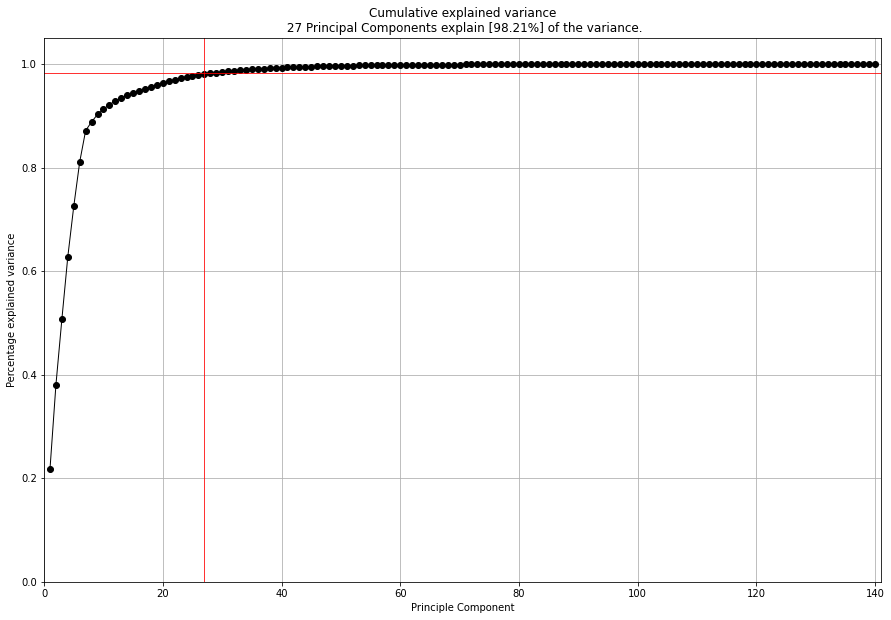

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 27 Principal Components explain [98.21%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [ ]:
model = pca(normalize=True, n_components= 0.98)

# Fit transform
results = model.fit_transform(wide_meteo)

scores = indexes_meteo.join(results['PC'])
# Plot the explained variance
model.plot()


In [ ]:
scores

,CAMPAÑA,ID_ESTACION,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
0,16,0,6.611235,11.852007,1.078890,7.172835,2.957660,1.498352,-2.227431,0.120566,...,-0.467092,1.856731,0.217502,-1.703981,-0.147052,-1.133144,-1.052213,-0.325874,-0.217112,0.162170
1,16,1,10.521355,5.725499,1.636717,7.893060,3.894543,-2.311744,4.447774,-1.094027,...,0.862821,-0.571515,1.062920,-0.036420,-0.122486,2.270286,0.400009,-0.194619,0.517583,-0.017972
2,16,2,7.110701,10.268823,0.322502,8.022201,1.734609,1.363155,-0.370028,2.364274,...,-0.382186,-0.213699,-1.365875,1.173369,0.619028,-1.064566,-1.202933,-0.581093,1.126311,-0.916695
3,16,3,8.300914,11.605126,1.962616,8.722070,3.655588,-1.104954,1.508951,-5.486193,...,-0.121160,-0.442498,-0.068058,-0.029413,-0.094206,-0.197702,0.375726,0.294858,-0.349577,-0.308838
4,16,4,7.410690,7.660739,0.754154,7.862848,2.957844,-0.188584,1.142499,7.151179,...,0.605669,-3.521603,-1.184420,0.622301,0.554989,0.611541,1.279127,0.613511,-0.001388,0.274564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,22,15,-10.120212,-5.927977,7.624497,5.134683,-0.610168,-4.205433,1.326703,-0.295621,...,-0.258347,0.469081,-0.461650,-0.061338,-0.615392,0.316881,-0.529017,-0.770868,0.018836,1.224432
136,22,16,-11.080815,-3.939797,8.041632,4.730138,-1.203678,-3.449513,-0.714725,-1.778593,...,-0.212861,0.039093,0.421920,0.485499,-0.106251,-0.033650,-0.756596,0.562997,0.156489,-0.561766
137,22,17,-9.173665,-11.126892,7.076977,8.214060,-0.417498,-6.864237,5.593198,1.409814,...,0.465727,-1.523579,3.663908,-0.876072,3.078774,-1.493537,1.575294,2.550356,0.613801,-0.649753
138,22,18,-11.633545,-3.079453,8.553031,4.413325,-0.132191,-2.649005,-1.782407,-1.986240,...,-0.203513,0.270418,0.455038,0.650335,-0.073516,-0.425869,0.047518,0.312840,0.607498,0.422509


### Merge y más depuración

In [ ]:
#merge
dfinal = pd.merge(dftrain, scores, on=['CAMPAÑA', 'ID_ESTACION'], how='left')
dfinal.reset_index(drop=True, inplace=True)

#después del merge 98% nulos para campaña 2014/15 así que eliminamos
dfinal = dfinal[~((dfinal.CAMPAÑA == 14)| (dfinal.CAMPAÑA == 15))]
dfinal.reset_index(drop=True, inplace=True)

dfinal['CAMPAÑA']=dfinal['CAMPAÑA'].astype('str').str[:2]

#guardamos los ids para crear después el dataset respuesta
ids = dfinal[dfinal['CAMPAÑA'].str.contains('22')][['ID_FINCA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE']]

# Guardando la data del 2022 aparte.
imput= dfinal[~dfinal['CAMPAÑA'].str.contains('22')]
imput22 = dfinal[dfinal['CAMPAÑA'].str.contains('22')]

#Quitando variable ID, VARIEDAD, TIPO Y COLOR 
imput = imput.loc[:,~imput.columns.str.contains('ID_', case=False)]
imput = imput.drop(columns=['VARIEDAD', 'TIPO', 'COLOR'])

#Separando la variable objetivo de las variables predictoras.
#transformamos a logaritmo para mejorar performance del modelo
varObjLog = np.log(imput.PRODUCCION)
imput_pred = imput.drop(['PRODUCCION'],axis=1)

#Quitando la variable campaña del dataset de predictores
imput_pred = imput_pred.drop(columns='CAMPAÑA', axis=1)

### Escalado

In [ ]:
#escalamos todas las variables juntas
scaler = StandardScaler()
imput_pred=pd.DataFrame(scaler.fit_transform(imput_pred), columns=imput_pred.columns)

# Feature selection (manual)

In [ ]:
X = sm.add_constant(imput_pred)

model = sm.OLS(varObjLog.values.ravel(), X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     131.9
Date:                Thu, 16 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:01:57   Log-Likelihood:                -9189.3
No. Observations:                6262   AIC:                         1.844e+04
Df Residuals:                    6231   BIC:                         1.865e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3920      0.013    631.056      0.000       8.366       8.418
ALTITUD        0.1286      0.025      5.055      0.000       0.079       0.178
SUPERFICIE     0.5869      0.014     41.306      0.000       0.559       0.615
MODO           0.3299      0.014     23.903      0.000       0.303       0.357
PC1           -0.5218      0.411     -1.271      0.204      -1.327       0.283
PC2           -0.0828      0.208     -0.398      0.691      -0.491       0.325
PC3            0.5756      0.402      1.430      0.153      -0.213       1.364
PC4            0.4186      0.314      1.332      0.183      -0.198       1.035
PC5           -0.1067      0.079     -1.355      0.175      -0.261       0.048
PC6           -0.0483      0.235     -0.205      0.838      -0.510       0.413
PC7           -0.1596      0.092     -1.730      0.084      -0.340       0.021
PC8            0.2872      0.067      4.313      0.000       0.157       0.418
PC9            0.0370      0.068      0.546      0.585      -0.096       0.170
PC10           0.0492      0.107      0.462      0.644      -0.160       0.258
PC11          -0.1462      0.117     -1.252      0.211      -0.375       0.083
PC12           0.0368      0.042      0.882      0.378      -0.045       0.119
PC13           0.1349      0.039      3.436      0.001       0.058       0.212
PC14           0.3137      0.043      7.238      0.000       0.229       0.399
PC15           0.2592      0.069      3.744      0.000       0.123       0.395
PC16           0.2112      0.085      2.484      0.013       0.045       0.378
PC17           0.2595      0.119      2.172      0.030       0.025       0.494
PC18          -0.0151      0.028     -0.545      0.586      -0.069       0.039
PC19          -0.1510      0.079     -1.923      0.055      -0.305       0.003
PC20          -0.3378      0.109     -3.093      0.002      -0.552      -0.124
PC21           0.2194      0.042      5.205      0.000       0.137       0.302
PC22          -0.2053      0.095     -2.152      0.031      -0.392      -0.018
PC23           0.0805      0.047      1.726      0.084      -0.011       0.172
PC24          -0.0604      0.035     -1.707      0.088      -0.130       0.009
PC25          -0.1260      0.048     -2.613      0.009      -0.221      -0.031
PC26           0.0352      0.029      1.226      0.220      -0.021       0.091
PC27           0.0633      0.028      2.275      0.023       0.009       0.118
==============================================================================
Omnibus:                     1435.172   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4514.265
Skew:                          -1.164   Prob(JB):                         0.00
Kurtosis:                       6.447   Cond. No.                         112.
==

In [ ]:
#eliminamos las variables que no son significativas
imput_pred = imput_pred.drop(columns=['PC7', 'PC13', 'PC16', 'PC17', 'PC18', 'PC20', 'PC21', 'PC26'], axis=1)
variables_predictoras = imput_pred.columns.to_list()

# Entrenamiento

In [ ]:
# Separando en training y test
X_train, X_test, y_train, y_test = train_test_split(imput_pred, varObjLog.values.ravel(), train_size = 0.8,
                                        random_state = 1234, shuffle = True)

In [ ]:
# Haciendo fit a los datos de train
rfr = RandomForestRegressor(random_state=1234, n_jobs=-1)
start_time = time.time()
rfr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.3f} seconds")

Tiempo de entrenamiento: 3.498 seconds


In [ ]:
print('Importancia de cada variable para el modelo:')

for i in range(len(variables_predictoras)):
  print(variables_predictoras[i], '--->', rfr.feature_importances_[i])

Importancia de cada variable para el modelo:
ALTITUD ---> 0.07704137192222321
SUPERFICIE ---> 0.6496942257547647
MODO ---> 0.055023630632002794
PC1 ---> 0.011733456562410137
PC2 ---> 0.010077218507534905
PC3 ---> 0.00886140756956256
PC4 ---> 0.011522463747025487
PC5 ---> 0.009901530869820385
PC6 ---> 0.008682832449928702
PC8 ---> 0.01639636590585099
PC9 ---> 0.013196772117359104
PC10 ---> 0.008385202024109513
PC11 ---> 0.013376965415138666
PC12 ---> 0.014124186285504933
PC14 ---> 0.015968299427490545
PC15 ---> 0.015125752087109588
PC19 ---> 0.009961643263990872
PC22 ---> 0.008597950575883442
PC23 ---> 0.013162326913487378
PC24 ---> 0.0107366920378889
PC25 ---> 0.009126382203534705
PC27 ---> 0.009303323727378517


# Validación del modelo

In [ ]:
#validación cruzada
scores = cross_val_score(rfr, imput_pred, varObjLog.values.ravel(), cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.54 accuracy with a standard deviation of 0.09


Root Mean squared error: 10859.20
Accuracy: 0.41


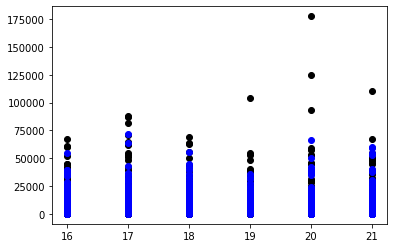

In [ ]:
y_pred=rfr.predict(X_test)

# Generando un dataset con los valores de test pero añadiendoa campaña para obtener el rmse de la predicción
X_test=X_test.join(imput['CAMPAÑA']).sort_values(by='CAMPAÑA')

# Graficando la predicción obtenida

# Cálculo de performance
#transformación inversa del logaritmo de la variable objetivo y accuracy ante los datos reales
print("Root Mean squared error: %.2f" % np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred))))
# The coefficient of determination: 1 is perfect prediction
print("Accuracy: %.2f" % r2_score(np.exp(y_test), np.exp(y_pred)))

# Gráfico de real frente a prediccion para alguna variable
plt.scatter(X_test.CAMPAÑA, np.exp(y_test), color="black")
plt.scatter(X_test.CAMPAÑA,np.exp(y_pred), color="blue")

# Predicción 2022

In [ ]:
# Haciendo fit a los datos de train
rfr = RandomForestRegressor(random_state=1234, n_jobs=-1)
start_time = time.time()
rfr.fit(imput_pred, varObjLog.values.ravel())
elapsed_time = time.time() - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.3f} seconds")

Tiempo de entrenamiento: 4.078 seconds


La complejidad del algoritmo RandomForestRegressor es de O(nlog(n)dk)



In [82]:
k = rfr.n_estimators
d = len(variables_predictoras)
n = len(imput_pred)

print(f'Complejidad de nuestro modelo final: O({n}log({n})({d})({k}))')

Complejidad de nuestro modelo final: O(6262log(6262)(22)(100))


In [ ]:
imput_pred22 = imput22.drop(['PRODUCCION'],axis=1) 

#Quitando variable ID, VARIEDAD, TIPO Y COLOR
imput_pred22 = imput_pred22.loc[:,~imput_pred22.columns.str.contains('ID_', case=False)]
imput_pred22 = imput_pred22.drop(columns=['VARIEDAD', 'TIPO', 'COLOR'])

#Quitando la variable campaña del dataset de predictores
imput_pred22 = imput_pred22.drop(columns='CAMPAÑA', axis=1)

# Generando un data set con solo las columnas seleccionadas
imput_pred22 = imput_pred22.loc[:, variables_predictoras]

#predicciones y montaje del dataset respuesta
predicciones22 = np.exp(rfr.predict(imput_pred22))
ids['PRODUCCION'] = predicciones22
ids.VARIEDAD = ids.VARIEDAD.astype('string')
ids.TIPO = ids.TIPO.astype('string')
ids = ids.sort_values(by=['ID_FINCA', 'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE'], ascending=True)
ids = ids.round(2)
ids.to_csv(r"Pynot_UH2023.txt", header=None, index=None, sep='|', decimal='.')